In [151]:
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
import sys
import re
import csv
import matplotlib.cm as cm
from copy import deepcopy
import numpy as np
import random
import pylab as plt
import sklearn as skl
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import torch
from copy import deepcopy
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as dataset
import torch.optim as optim
import seaborn as sb
import json
import matplotlib.patches as patches
import json
import rdflib

def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()
    
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax
    
# data downloaded from
# https://github.com/kidehen/worldcup2014/blob/master/data
# code recreated from 
# https://github.com/jimmywangheng/knowledge_representation_pytorch/blob/master/transE_pytorch.py

# Importing data and construct triples

In [152]:
g = rdflib.Graph()
g.parse('/Users/lingfeiw/Documents/bigdata/worldcup2014-master/data.ttl',format="n3")
len(g)

5411

In [153]:
def cleanRDF(s): 
    if isinstance(s, rdflib.URIRef):
        s=s.toPython().split('/')[-1]
        if '#' in s:
            s=s.split('#')[-1]
        return s
    elif isinstance(s, rdflib.Literal):
        return s.toPython()
    else:
        pass

relations=['age','hasPosition','isMemberOf'] # many-to-one cases
data=[]
for h, r, t in g:
    h,r,t=list(map(cleanRDF,[h,r,t]))
    if r in relations:
        if r=='age':
            r='isAgeOf'
        data.append((h,r,t))
    #if r=='member' and 'Stage' not in h and 'team' not in h:# group vs team, one-to-many 
    #    data.append((h,'groupMember',t))
    
entityDic={k:n for n,k in enumerate(set([j for i in data for j in [i[0],i[-1]]]))}
relationDic={k:n for n,k in enumerate(set([i[1] for i in data]))}
entityDic_={k:n for n,k in entityDic.items()}
relationDic_={k:n for n,k in relationDic.items()}

In [154]:
# functions to assign a type for each entity, only complex for this dataset
types={}
types_=defaultdict(lambda:[])
for h, r, t in g:
    h,r,t=list(map(cleanRDF,[h,r,t]))
    if r=='type' and h in entityDic:
        if t=='Group':
            if 'team' in h:
                types[h]='Team'
                types_['Team'].append(h)
            else:
                continue
        else:
            types[h]=t
            types_[t].append(h)
for i in entityDic:
    if i not in types:
        if isinstance(i,int):
            types[i]='age'
            types_['age'].append(i)
        else:
            types[i]='position'
            types_['position'].append(i)

In [69]:
types_.keys()

dict_keys(['Person', 'Team', 'age', 'position'])

In [70]:
relationDic_

{0: 'hasPosition', 1: 'isMemberOf', 2: 'isAgeOf'}

In [72]:
len(data)

2207

In [73]:
data[:6]

[('brayan-beckeles', 'hasPosition', 'Defender'),
 ('alexander-samedov', 'hasPosition', 'Forward'),
 ('alexandros-tziolis', 'isAgeOf', 29),
 ('carl-medjani', 'hasPosition', 'Defender'),
 ('patrick-pemberton', 'hasPosition', 'Goalkeeper'),
 ('victor-bernardez', 'isAgeOf', 32)]

# Build and train TransE models

In [155]:
class transE(nn.Module):

    def __init__(self, entity_size, relation_size, embedding_size):
        super(transE, self).__init__()

        self.W_en = nn.Embedding(entity_size, embedding_size)
        self.W_re = nn.Embedding(relation_size, embedding_size)

    def forward(self, pos_h, pos_r,  pos_t, neg_h, neg_r, neg_t): 
        pos_h_e = self.W_en(pos_h)
        pos_t_e = self.W_en(pos_t)
        pos_r_e = self.W_re(pos_r)
        neg_h_e = self.W_en(neg_h)
        neg_t_e = self.W_en(neg_t)
        neg_r_e = self.W_re(neg_r)
            
        posError = torch.sum((pos_h_e + pos_r_e - pos_t_e) ** 2)
        negError = torch.sum((neg_h_e + neg_r_e - neg_t_e) ** 2)
        return posError
    
# Split the tripleList into batches 
def getBatchList(tripleList, num_batches):
    batchSize = len(tripleList) // num_batches
    batchList = [0] * num_batches
    for i in range(num_batches - 1):
        batchList[i] = tripleList[i * batchSize : (i + 1) * batchSize]
    batchList[num_batches - 1] = tripleList[(num_batches - 1) * batchSize : ]
    return batchList

# randomly generate negative samples by corrupting head or tail with equal probabilities,
# without checking whether false negative samples exist.
def getBatch(tripleList, entity_size):
    newTripleList = [corrupt_head(triple, entity_size) if random.random() < 0.5 
                     else corrupt_tail(triple, entity_size) for triple in tripleList]
    ph, pt ,pr = list(zip(*tripleList))
    nh, nt, nr = list(zip(*newTripleList))
    return ph, pt, pr, nh, nt, nr

def corrupt_head(triple, entity_size):
    return (np.random.randint(entity_size),triple[1],triple[2])

def corrupt_tail(triple, entity_size):
    return (triple[0],triple[1],np.random.randint(entity_size))


In [61]:
entity_size=len(entityDic)
relation_size=len(relationDic)
embedding_size=2
#triples=list(zip(range(9),[0]*10,range(1,10)))
triples= [(entityDic[i],relationDic[j],entityDic[k]) for i,j,k in data]
nBatch=10
trainBatchList=getBatchList(triples, nBatch)
transe = transE(entity_size, relation_size, embedding_size)

# training
num_epochs = 1000
learning_rate = 0.001
optimizer = optim.Adam(transe.parameters(), lr=learning_rate)
Loss=[]
posEnData={}
posReData={}
for epo in range(num_epochs):
    total_loss = 0
    for batchList in trainBatchList:
        optimizer.zero_grad()
        pos_h_batch, pos_r_batch, pos_t_batch, neg_h_batch,neg_r_batch, neg_t_batch=getBatch(batchList,entity_size)
        pos_h_batch = torch.LongTensor(pos_h_batch)
        pos_t_batch = torch.LongTensor(pos_t_batch)
        pos_r_batch = torch.LongTensor(pos_r_batch)
        neg_h_batch = torch.LongTensor(neg_h_batch)
        neg_t_batch = torch.LongTensor(neg_t_batch)
        neg_r_batch = torch.LongTensor(neg_r_batch)
        
        loss = transe(pos_h_batch, pos_r_batch, pos_t_batch, neg_h_batch,neg_r_batch, neg_t_batch)
    
        total_loss += loss.item()
        #transe.W_in.weight.data[0][0]=0# fix the position of "9"
        #transe.W_in.weight.data[1][0]=0#
        loss.backward()
        optimizer.step()
    if epo % 100 == 0:    
        print(f'Loss at epo {epo}: {total_loss/len(triples)}')# print average loss within an epoch
    posEnData[epo]=deepcopy(transe.W_en.weight.data.numpy())
    posReData[epo]=deepcopy(transe.W_re.weight.data.numpy())
    Loss.append(total_loss/len(triples))

Loss at epo 0: 6.02628239647641
Loss at epo 100: 1.6372003248497324
Loss at epo 200: 0.601685925420183
Loss at epo 300: 0.233802539599012
Loss at epo 400: 0.08786573872395538
Loss at epo 500: 0.031616729041489745
Loss at epo 600: 0.010983279456798448
Loss at epo 700: 0.0037029689261423933
Loss at epo 800: 0.0012086525653950163
Loss at epo 900: 0.00036065848957786043


Text(0, 0.5, 'Loss')

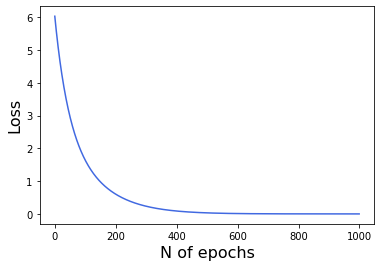

In [62]:
plt.plot(Loss,color='RoyalBlue',marker='')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

# high dimension experiment

In [156]:
entity_size=len(entityDic)
relation_size=len(relationDic)
embedding_size=10
#triples=list(zip(range(9),[0]*10,range(1,10)))
triples= [(entityDic[i],relationDic[j],entityDic[k]) for i,j,k in data]
nBatch=10
trainBatchList=getBatchList(triples, nBatch)
transe = transE(entity_size, relation_size, embedding_size)

# training
num_epochs = 1000
learning_rate = 0.001
optimizer = optim.Adam(transe.parameters(), lr=learning_rate)
Loss=[]
posEnData={}
posReData={}
for epo in range(num_epochs):
    total_loss = 0
    for batchList in trainBatchList:
        optimizer.zero_grad()
        pos_h_batch, pos_r_batch, pos_t_batch, neg_h_batch,neg_r_batch, neg_t_batch=getBatch(batchList,entity_size)
        pos_h_batch = torch.LongTensor(pos_h_batch)
        pos_t_batch = torch.LongTensor(pos_t_batch)
        pos_r_batch = torch.LongTensor(pos_r_batch)
        neg_h_batch = torch.LongTensor(neg_h_batch)
        neg_t_batch = torch.LongTensor(neg_t_batch)
        neg_r_batch = torch.LongTensor(neg_r_batch)
        
        loss = transe(pos_h_batch, pos_r_batch, pos_t_batch, neg_h_batch,neg_r_batch, neg_t_batch)
    
        total_loss += loss.item()
        #transe.W_in.weight.data[0][0]=0# fix the position of "9"
        #transe.W_in.weight.data[1][0]=0#
        loss.backward()
        optimizer.step()
    if epo % 100 == 0:    
        print(f'Loss at epo {epo}: {total_loss/len(triples)}')# print average loss within an epoch
    posEnData[epo]=deepcopy(transe.W_en.weight.data.numpy())
    posReData[epo]=deepcopy(transe.W_re.weight.data.numpy())
    Loss.append(total_loss/len(triples))

Loss at epo 0: 31.014405292464318
Loss at epo 100: 9.357730452378087
Loss at epo 200: 3.464234062163712
Loss at epo 300: 1.3343480554813165
Loss at epo 400: 0.4972055052328175
Loss at epo 500: 0.16921189796022554
Loss at epo 600: 0.0506518177711753
Loss at epo 700: 0.01318809945063727
Loss at epo 800: 0.0031113750358269555
Loss at epo 900: 0.0007598057311613959


Text(0, 0.5, 'Loss')

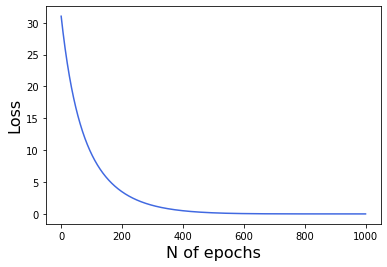

In [157]:
plt.plot(Loss,color='RoyalBlue',marker='')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

# visualize results

In [159]:
colorMap={k:n for n,k in enumerate(types_.keys())}
relationColor={'isMemberOf':1,'isAgeOf':2,'hasPosition':3}# match type color
entityColors={i:colorMap[types[i]] for i in entityDic}
messi=[i for i in data if 'lionel-messi' in i[0]]
markers=['o','^','D','s']

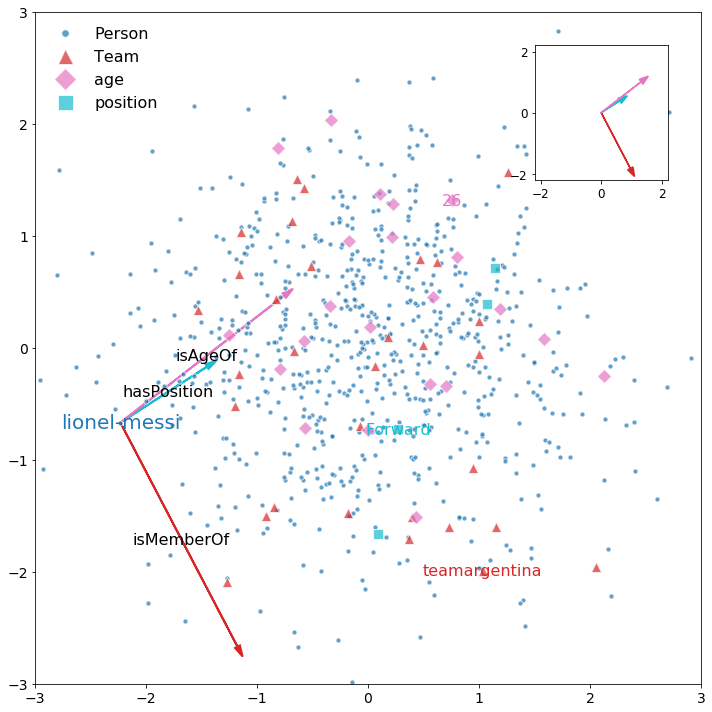

In [149]:
#posEn=dict(zip(entityDic_.values(),transe.W_en.weight.data.numpy()))
#posRe=dict(zip(relationDic_.values(),transe.W_re.weight.data.numpy()))
maxl=3# zoom in over time 
minl=1
#epo=num_epochs-1
epo=0
posEn=dict(zip(entityDic_.values(),posEnData[epo]))
posRe=dict(zip(relationDic_.values(),posReData[epo]))

fig = plt.figure(figsize=(10, 10),facecolor='white')
cp = cm.get_cmap('tab10',len(types_))
ax = fig.add_subplot(111)
for t in types_:
    idx=list(types_.keys()).index(t)
    x,y=np.array([posEn[i] for i in types_[t]]).T
    s=5
    if idx>0:#non person
        s=10
    plt.plot(x,y,linestyle='',marker=markers[idx],markersize=s,markeredgecolor='white',
             markerfacecolor=cp(idx),label=t,alpha=0.7)
#
i='lionel-messi'
xi,yi=posEn[i]
idx=list(types_.keys()).index(types[i])
plt.text(xi,yi,i,va='center',ha='center',size=20,color=cp(idx))

for h,r,t in messi:
    xh,yh=posEn[h]
    xr,yr=posRe[r]
    xt,yt=posEn[t]
    plt.arrow(xh, yh,xr, yr, linewidth=2,length_includes_head=True,
          head_width=0.05, head_length=0.1,color=cp(relationColor[r]))
    plt.text((xh+xh+xr)/2,(yh+yh+yr)/2,r,va='center',ha='center',size=16,color='k')
    plt.text(xt,yt,t,va='center',ha='center',color=cp(relationColor[r]),size=16)
    idx=list(types_.keys()).index(types[t])
plt.xticks([-3,-2,-1,0,1,2,3])
plt.yticks([-3,-2,-1,0,1,2,3])
ax.tick_params(axis='both', which='major', labelsize=14)
    

plt.legend(loc=2,frameon=False,markerscale=1.5,fontsize=16)
#deltal=(maxl-minl)*epo/num_epochs
#nl=maxl-deltal
#nl=minl+nl**3/maxl**2
#plt.xlim(-nl,nl)
#plt.ylim(-nl,nl) 
nl=3
plt.xlim(-nl,nl)
plt.ylim(-nl,nl) 
plt.tight_layout()
#
subax = add_subplot_axes(ax,[.75,.75,0.2,0.2])
#epo=num_epochs-1
for r in posRe:
    xr,yr=posRe[r]
    subax.arrow(0, 0,xr, yr, linewidth=1.5,length_includes_head=True,
          head_width=0.2, head_length=0.3,color=cp(relationColor[r]))
nl=2.2
plt.xlim(-nl,nl)
plt.ylim(-nl,nl)
plt.xticks([-2,0,2])
plt.yticks([-2,0,2])
subax.tick_params(axis='both', which='major', labelsize=12)
#


In [81]:
posRe

{'isMemberOf': array([ 0.16400461, -0.7035457 ], dtype=float32),
 'hasPosition': array([ 0.6055704 , -0.38227686], dtype=float32),
 'isAgeOf': array([0.5882386, 0.5302453], dtype=float32)}

# visualize high dimensional results

In [169]:
from sklearn.decomposition import PCA
epo=num_epochs-1
posEn=dict(zip(entityDic_.values(),PCA(n_components=2).fit_transform(posEnData[epo])))
posRe=dict(zip(relationDic_.values(),PCA(n_components=2).fit_transform(posReData[epo])))

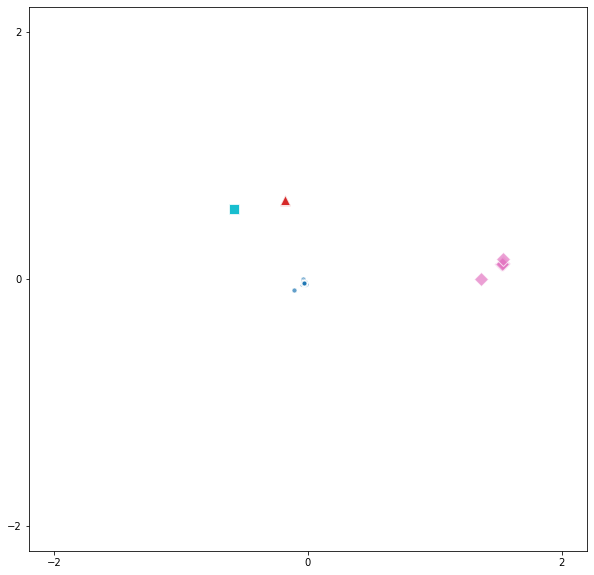

In [171]:
fig = plt.figure(figsize=(10, 10),facecolor='white')
cp = cm.get_cmap('tab10',len(types_))
ax = fig.add_subplot(111)
for t in types_:
    idx=list(types_.keys()).index(t)
    x,y=np.array([posEn[i] for i in types_[t]]).T
    s=5
    if idx>0:#non person
        s=10
    plt.plot(x,y,linestyle='',marker=markers[idx],markersize=s,markeredgecolor='white',
             markerfacecolor=cp(idx),label=t,alpha=0.7)
#
i='lionel-messi'
xi,yi=posEn[i]
idx=list(types_.keys()).index(types[i])
plt.text(xi,yi,i,va='center',ha='center',size=20,color=cp(idx))

for h,r,t in messi:
    xh,yh=posEn[h]
    xr,yr=posRe[r]
    xt,yt=posEn[t]
    plt.arrow(xh, yh,xr, yr, linewidth=2,length_includes_head=True,
          head_width=0.05, head_length=0.1,color=cp(relationColor[r]))
    plt.text((xh+xh+xr)/2,(yh+yh+yr)/2,r,va='center',ha='center',size=16,color='k')
    plt.text(xt,yt,t,va='center',ha='center',color=cp(relationColor[r]),size=16)
    idx=list(types_.keys()).index(types[t])
plt.xticks([-3,-2,-1,0,1,2,3])
plt.yticks([-3,-2,-1,0,1,2,3])
ax.tick_params(axis='both', which='major', labelsize=14)
    

plt.legend(loc=2,frameon=False,markerscale=1.5,fontsize=16)
#deltal=(maxl-minl)*epo/num_epochs
#nl=maxl-deltal
#nl=minl+nl**3/maxl**2
#plt.xlim(-nl,nl)
#plt.ylim(-nl,nl) 
nl=3
plt.xlim(-nl,nl)
plt.ylim(-nl,nl) 
plt.tight_layout()
#
subax = add_subplot_axes(ax,[.75,.75,0.2,0.2])
#epo=num_epochs-1
for r in posRe:
    xr,yr=posRe[r]
    subax.arrow(0, 0,xr, yr, linewidth=1.5,length_includes_head=True,
          head_width=0.2, head_length=0.3,color=cp(relationColor[r]))
nl=2.2
plt.xlim(-nl,nl)
plt.ylim(-nl,nl)
plt.xticks([-2,0,2])
plt.yticks([-2,0,2])
subax.tick_params(axis='both', which='major', labelsize=12)
#


# make videos

In [150]:
maxl=3# zoom in over time 
minl=1
for epo in range(num_epochs):
    flushPrint(epo)
    posEn=dict(zip(entityDic_.values(),posEnData[epo]))
    posRe=dict(zip(relationDic_.values(),posReData[epo]))
    #
    fig = plt.figure(figsize=(10, 10),facecolor='white')
    cp = cm.get_cmap('tab10',len(types_))
    ax = fig.add_subplot(111)
    for t in types_:
        idx=list(types_.keys()).index(t)
        x,y=np.array([posEn[i] for i in types_[t]]).T
        s=5
        if idx>0:#non person
            s=10
        plt.plot(x,y,linestyle='',marker=markers[idx],markersize=s,markeredgecolor='white',
                 markerfacecolor=cp(idx),label=t,alpha=0.7)
    #
    i='lionel-messi'
    xi,yi=posEn[i]
    idx=list(types_.keys()).index(types[i])
    plt.text(xi,yi,i,va='center',ha='center',size=20,color=cp(idx))

    for h,r,t in messi:
        xh,yh=posEn[h]
        xr,yr=posRe[r]
        xt,yt=posEn[t]
        plt.arrow(xh, yh,xr, yr, linewidth=2,length_includes_head=True,
              head_width=0.05, head_length=0.1,color=cp(relationColor[r]))
        plt.text((xh+xh+xr)/2,(yh+yh+yr)/2,r,va='center',ha='center',size=16,color='k')
        plt.text(xt,yt,t,va='center',ha='center',color=cp(relationColor[r]),size=16)
        idx=list(types_.keys()).index(types[t])

    plt.xticks([-3,-2,-1,0,1,2,3])
    plt.yticks([-3,-2,-1,0,1,2,3])
    ax.tick_params(axis='both', which='major', labelsize=14)
        
        
    plt.legend(loc=2,frameon=False,markerscale=1.5,fontsize=16) 
    # zoom in over time 
    deltal=(maxl-minl)*epo/num_epochs
    nl=maxl-deltal
    nl=minl+nl**3/maxl**2
    nl=3# fix the axis of the main figure
    plt.xlim(-nl,nl)
    plt.ylim(-nl,nl)  
    plt.tight_layout()

    #
    subax = add_subplot_axes(ax,[.75,.75,0.2,0.2])
    #epo=num_epochs-1
    for r in posRe:
        xr,yr=posRe[r]
        subax.arrow(0, 0,xr, yr, linewidth=1.5,length_includes_head=True,
              head_width=0.2, head_length=0.3,color=cp(relationColor[r]))
    nl=2.2
    plt.xlim(-nl,nl)
    plt.ylim(-nl,nl)
    plt.xticks([-2,0,2])
    plt.yticks([-2,0,2])
    subax.tick_params(axis='both', which='major', labelsize=12)
    
    
    plt.savefig("/Users/lingfeiw/Dropbox/ScienceInAction/StudyGroup/transEwordcupAnnimation_fixed/image_{:03d}.png".\
                format(epo))
    plt.close()

999

In [ ]:
'''
# cd to the folder with pngs and run:
# "-r 60" is the framerate
ffmpeg -r 60 -f image2 -pattern_type glob -i "*?png" -vcodec libx264 -crf 20 -pix_fmt yuv420p /Users/lingfeiw/Dropbox/ScienceInAction/StudyGroup/animation.mp4
'''

In [299]:
1000/60

16.666666666666668